# XY - Regression - Group 11

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import random as rn
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Video

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
#from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import torchvision.models as models
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split

In [8]:
class LaneDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None): # prev None
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir

        # Transformations
        self.transform = transform if transform else transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            # Normalize using ImageNet stats (standard for ResNet)
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0] # Filename
        img_path = os.path.join(self.root_dir, img_id)
        
        # Check if file exists in folder
        # if image does not ecist take next image
        if not os.path.exists(img_path):
            return self.__getitem__((index + 1) % len(self.annotations))

        image = Image.open(img_path).convert("RGB")

        # Get the X, Y coordinates
        label = torch.tensor(
            self.annotations.iloc[index, 1:7].values.astype('float32')
        ) # Columns 1 to 6 are labels (coordinates for the three points

        if self.transform:
            image = self.transform(image)
        return image, label

In [9]:
# Hyperparameters
batch_size = 8

#data_dir = r"C:\Users\agah2\Desktop\JupyterNotebooks\BIP\BIP_images_roboter_cam_allinone\all"
#csv_file = "labels.csv"

data_dir = "./dataset/all_small_dataset"
csv_file = "./dataset/labels_center_and_lanes.csv"

# Ratio: 80% train, 10% test, 10% validation
train_dir = "./dataset/train_small_dataset" # Training Dataset
test_dir = "./dataset/test_small_dataset"   # Testing Dataset
val_dir = "./dataset/val_small_dataset"     # Validation Dataset

In [10]:
full_dataset = LaneDataset(csv_file=csv_file, root_dir=data_dir)

train_dataset = LaneDataset(csv_file = csv_file, root_dir = train_dir)
test_dataset = LaneDataset(csv_file = csv_file, root_dir = test_dir)
val_dataset = LaneDataset(csv_file = csv_file, root_dir = val_dir)

In [11]:
# Split into Train (80%) and Validation (20%)
#train_size = int(0.8 * len(full_dataset))
#test_size = len(full_dataset) - train_size
#train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

#train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
#test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)  # check if shuffle needs to be done here too

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)#, drop_last=True) # drop last avoids error
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

Labels have values ranging from 0 to 1, normalized to image resolution

In [12]:
# Setup Model
# Load ResNet18 pre-trained on ImageNet
model = models.resnet18(weights = True) # prev: weights = True # resnet18 prev

# Modify the final layer: Input features -> 6 Output features (X, Y)
model.fc = nn.Linear(model.fc.in_features, 6)

# Freeze all layers so training doesnt change the weight/biases
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the fc layer
for param in model.fc.parameters():
    param.requires_grad = True

C:\Users\agah2\miniconda3\envs\bip\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

cuda


In [14]:
summary(model, input_size = (3, 224, 224))    # if using torchsummary 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [15]:
# Hyperparameters
lr = 1e-4
epochs = 80

# Training Setup
optimizer = optim.AdamW(model.parameters(), lr=lr)
#loss_fn = nn.MSELoss() # Mean Squared Error
#loss_fn = nn.L1Loss() # Mean Absolute Error

# Huber Loss could be better
loss_fn = nn.SmoothL1Loss()

print(f"Training on {device} with {len(train_dataset)} images...")

Training on cuda with 1160 images...


In [16]:
train_losses = []
val_losses = []
train_maes = [] # mean absolut error (between prediction and label)
val_maes = []

# calculate metric for regression (accuracy)
def calculate_mae(outputs, labels):
    return torch.abs(outputs - labels).mean().item() # how far is the prediction off to the actual labels (groudn truth)

In [100]:
# Train not only the last layer but all convolutional layers. Previoua conv layers with smaller lr

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Apply different learning rates
optimizer = torch.optim.AdamW([
    {'params': model.conv1.parameters(), 'lr': 1e-6}, # First layer
    {'params': model.layer1.parameters(), 'lr': 1e-6},
    {'params': model.layer2.parameters(), 'lr': 1e-5},
    {'params': model.layer3.parameters(), 'lr': 1e-5}, # Middle
    {'params': model.layer4.parameters(), 'lr': 1e-5}, 
    {'params': model.fc.parameters(), 'lr': 1e-4}    
], lr=1e-4)


In [101]:
#image, label = train_dataset[0] 

#print(image.shape) # Returns the normalized tensor
#print(label)       # Returns the coordinates tensor

In [103]:
best_val_loss = float('inf')

# training loop
for epoch in range(epochs):
    # training
    model.train()
    running_loss = 0.0
    running_mae = 0.0

    # loading bar for showing progress
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", unit="batch", leave=False)

    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        current_mae = calculate_mae(outputs, labels)
        running_mae += current_mae

        # Update the progress bar with the current batch loss
        train_bar.set_postfix(loss=f"{loss.item():.4f}", mae=f"{current_mae:.4f}")

    avg_train_loss = running_loss / len(train_loader)
    avg_train_mae = running_mae / len(train_loader)
    train_losses.append(avg_train_loss)
    train_maes.append(avg_train_mae)

    # validation
    model.eval()
    running_val_loss = 0.0
    running_val_mae = 0.0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", unit="batch", leave=False)

    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            v_loss = loss_fn(outputs, labels).item()
            v_mae = calculate_mae(outputs, labels)

            running_val_loss += v_loss
            running_val_mae += v_mae

            val_bar.set_postfix(val_loss=f"{v_loss:.4f}", val_mae=f"{v_mae:.4f}")

    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_mae = running_val_mae / len(val_loader)
    val_losses.append(avg_val_loss)
    val_maes.append(avg_val_mae)

    # print losses etc
    print(f"Epoch {epoch+1} / {epochs}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val MAE: {avg_val_mae:.4f}")

    # Save the best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), './models/best_steering_model_xy_ResNet18_center_and_lanes_differential_ft.pth')
        print("Saved Best Model (Validation Loss Improved)\n")

print("\n Training Done") 

Epoch 1 / 80: Train Loss: 0.0110 | Val Loss: 0.0105 | Val MAE: 0.1151
Saved Best Model (Validation Loss Improved)



Epoch 2 / 80: Train Loss: 0.0084 | Val Loss: 0.0088 | Val MAE: 0.1056
Saved Best Model (Validation Loss Improved)



Epoch 3 / 80: Train Loss: 0.0064 | Val Loss: 0.0061 | Val MAE: 0.0862
Saved Best Model (Validation Loss Improved)



Epoch 4 / 80: Train Loss: 0.0055 | Val Loss: 0.0057 | Val MAE: 0.0833
Saved Best Model (Validation Loss Improved)



Epoch 5 / 80: Train Loss: 0.0045 | Val Loss: 0.0048 | Val MAE: 0.0762
Saved Best Model (Validation Loss Improved)



Epoch 6 / 80: Train Loss: 0.0040 | Val Loss: 0.0042 | Val MAE: 0.0720
Saved Best Model (Validation Loss Improved)



Epoch 7 / 80: Train Loss: 0.0036 | Val Loss: 0.0038 | Val MAE: 0.0673
Saved Best Model (Validation Loss Improved)



Epoch 8 / 80: Train Loss: 0.0033 | Val Loss: 0.0035 | Val MAE: 0.0653
Saved Best Model (Validation Loss Improved)



Epoch 9 / 80: Train Loss: 0.0029 | Val Loss: 0.0030 | Val MAE: 0.0591
Saved Best Model (Validation Loss Improved)



Epoch 10 / 80: Train Loss: 0.0028 | Val Loss: 0.0027 | Val MAE: 0.0573
Saved Best Model (Validation Loss Improved)



Epoch 11 / 80: Train Loss: 0.0024 | Val Loss: 0.0027 | Val MAE: 0.0569
Saved Best Model (Validation Loss Improved)



Epoch 12 / 80: Train Loss: 0.0023 | Val Loss: 0.0023 | Val MAE: 0.0524
Saved Best Model (Validation Loss Improved)



Epoch 13 / 80: Train Loss: 0.0020 | Val Loss: 0.0021 | Val MAE: 0.0510
Saved Best Model (Validation Loss Improved)



Epoch 14 / 80: Train Loss: 0.0019 | Val Loss: 0.0023 | Val MAE: 0.0521


Epoch 15 / 80: Train Loss: 0.0017 | Val Loss: 0.0016 | Val MAE: 0.0432
Saved Best Model (Validation Loss Improved)



Epoch 16 / 80: Train Loss: 0.0017 | Val Loss: 0.0021 | Val MAE: 0.0513


Epoch 17 / 80: Train Loss: 0.0016 | Val Loss: 0.0018 | Val MAE: 0.0466


Epoch 18 / 80: Train Loss: 0.0015 | Val Loss: 0.0015 | Val MAE: 0.0418
Saved Best Model (Validation Loss Improved)



Epoch 19 / 80: Train Loss: 0.0013 | Val Loss: 0.0014 | Val MAE: 0.0418
Saved Best Model (Validation Loss Improved)



Epoch 20 / 80: Train Loss: 0.0013 | Val Loss: 0.0012 | Val MAE: 0.0383
Saved Best Model (Validation Loss Improved)



Epoch 21 / 80: Train Loss: 0.0013 | Val Loss: 0.0012 | Val MAE: 0.0377
Saved Best Model (Validation Loss Improved)



Epoch 22 / 80: Train Loss: 0.0012 | Val Loss: 0.0011 | Val MAE: 0.0358
Saved Best Model (Validation Loss Improved)



Epoch 23 / 80: Train Loss: 0.0010 | Val Loss: 0.0011 | Val MAE: 0.0361


Epoch 24 / 80: Train Loss: 0.0011 | Val Loss: 0.0010 | Val MAE: 0.0344
Saved Best Model (Validation Loss Improved)



Epoch 25 / 80: Train Loss: 0.0010 | Val Loss: 0.0010 | Val MAE: 0.0336
Saved Best Model (Validation Loss Improved)



Epoch 26 / 80: Train Loss: 0.0009 | Val Loss: 0.0010 | Val MAE: 0.0337


Epoch 27 / 80: Train Loss: 0.0009 | Val Loss: 0.0010 | Val MAE: 0.0336


Epoch 28 / 80: Train Loss: 0.0009 | Val Loss: 0.0012 | Val MAE: 0.0380


Epoch 29 / 80: Train Loss: 0.0008 | Val Loss: 0.0008 | Val MAE: 0.0303
Saved Best Model (Validation Loss Improved)



Epoch 30 / 80: Train Loss: 0.0009 | Val Loss: 0.0008 | Val MAE: 0.0297
Saved Best Model (Validation Loss Improved)



Epoch 31 / 80: Train Loss: 0.0007 | Val Loss: 0.0011 | Val MAE: 0.0367


Epoch 32 / 80: Train Loss: 0.0007 | Val Loss: 0.0008 | Val MAE: 0.0295


Epoch 33 / 80: Train Loss: 0.0007 | Val Loss: 0.0009 | Val MAE: 0.0325


Epoch 34 / 80: Train Loss: 0.0007 | Val Loss: 0.0007 | Val MAE: 0.0274
Saved Best Model (Validation Loss Improved)



Epoch 35 / 80: Train Loss: 0.0006 | Val Loss: 0.0007 | Val MAE: 0.0277


Epoch 36 / 80: Train Loss: 0.0006 | Val Loss: 0.0007 | Val MAE: 0.0275
Saved Best Model (Validation Loss Improved)



Epoch 37 / 80: Train Loss: 0.0006 | Val Loss: 0.0007 | Val MAE: 0.0274
Saved Best Model (Validation Loss Improved)



Epoch 38 / 80: Train Loss: 0.0005 | Val Loss: 0.0007 | Val MAE: 0.0269


Epoch 39 / 80: Train Loss: 0.0005 | Val Loss: 0.0006 | Val MAE: 0.0262
Saved Best Model (Validation Loss Improved)



Epoch 40 / 80: Train Loss: 0.0005 | Val Loss: 0.0012 | Val MAE: 0.0368


Epoch 41 / 80: Train Loss: 0.0005 | Val Loss: 0.0006 | Val MAE: 0.0258
Saved Best Model (Validation Loss Improved)



Epoch 42 / 80: Train Loss: 0.0004 | Val Loss: 0.0007 | Val MAE: 0.0266


Epoch 43 / 80: Train Loss: 0.0004 | Val Loss: 0.0006 | Val MAE: 0.0269


Epoch 44 / 80: Train Loss: 0.0004 | Val Loss: 0.0006 | Val MAE: 0.0248
Saved Best Model (Validation Loss Improved)



Epoch 45 / 80: Train Loss: 0.0004 | Val Loss: 0.0006 | Val MAE: 0.0244
Saved Best Model (Validation Loss Improved)



Epoch 46 / 80: Train Loss: 0.0004 | Val Loss: 0.0006 | Val MAE: 0.0246


Epoch 47 / 80: Train Loss: 0.0004 | Val Loss: 0.0006 | Val MAE: 0.0255


Epoch 48 / 80: Train Loss: 0.0004 | Val Loss: 0.0005 | Val MAE: 0.0224
Saved Best Model (Validation Loss Improved)



Epoch 49 / 80: Train Loss: 0.0003 | Val Loss: 0.0005 | Val MAE: 0.0231


Epoch 50 / 80: Train Loss: 0.0003 | Val Loss: 0.0005 | Val MAE: 0.0220
Saved Best Model (Validation Loss Improved)



Epoch 51 / 80: Train Loss: 0.0003 | Val Loss: 0.0006 | Val MAE: 0.0247


Epoch 52 / 80: Train Loss: 0.0003 | Val Loss: 0.0004 | Val MAE: 0.0198
Saved Best Model (Validation Loss Improved)



Epoch 53 / 80: Train Loss: 0.0003 | Val Loss: 0.0006 | Val MAE: 0.0270


Epoch 54 / 80: Train Loss: 0.0003 | Val Loss: 0.0004 | Val MAE: 0.0203


Epoch 55 / 80: Train Loss: 0.0003 | Val Loss: 0.0006 | Val MAE: 0.0253


Epoch 56 / 80: Train Loss: 0.0003 | Val Loss: 0.0006 | Val MAE: 0.0254


Epoch 57 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0202


Epoch 58 / 80: Train Loss: 0.0003 | Val Loss: 0.0004 | Val MAE: 0.0208


Epoch 59 / 80: Train Loss: 0.0002 | Val Loss: 0.0005 | Val MAE: 0.0219


Epoch 60 / 80: Train Loss: 0.0003 | Val Loss: 0.0005 | Val MAE: 0.0232


Epoch 61 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0197


Epoch 62 / 80: Train Loss: 0.0002 | Val Loss: 0.0005 | Val MAE: 0.0219


Epoch 63 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0198


Epoch 64 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0201


Epoch 65 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0216


Epoch 66 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0187
Saved Best Model (Validation Loss Improved)



Epoch 67 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0197


Epoch 68 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0193


Epoch 69 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0194


Epoch 70 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0208


Epoch 71 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0214


Epoch 72 / 80: Train Loss: 0.0002 | Val Loss: 0.0005 | Val MAE: 0.0213


Epoch 73 / 80: Train Loss: 0.0002 | Val Loss: 0.0006 | Val MAE: 0.0248


Epoch 74 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0188


Epoch 75 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0183


Epoch 76 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0196


Epoch 77 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0198


Epoch 78 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0182
Saved Best Model (Validation Loss Improved)



Epoch 79 / 80: Train Loss: 0.0001 | Val Loss: 0.0004 | Val MAE: 0.0205


Epoch 80 / 80: Train Loss: 0.0002 | Val Loss: 0.0004 | Val MAE: 0.0175
Saved Best Model (Validation Loss Improved)


 Training Done


In [124]:
print("Evaluating on Test Set")

model.load_state_dict(torch.load('./models/best_steering_model_xy_ResNet18_center_and_lanes_differential_ft.pth')) # Load best version
model.eval()

final_test_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        loss = loss_fn(outputs, labels)
        final_test_loss += loss.item()

avg_test_loss = final_test_loss / len(test_loader)
print(f"Final Test Loss: {avg_test_loss:.4f}")

Evaluating on Test Set
Final Test Loss: 0.0003


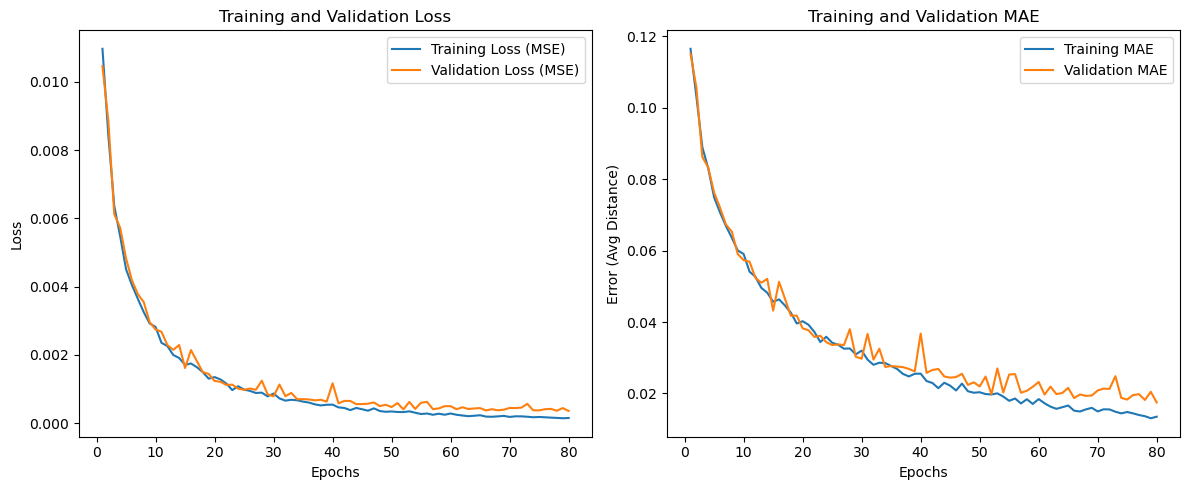

In [125]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot 1: Loss (MSE)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss (MSE)')
plt.plot(epochs_range, val_losses, label='Validation Loss (MSE)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot 2: Mean Absolute Error (MAE)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_maes, label='Training MAE')
plt.plot(epochs_range, val_maes, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Error (Avg Distance)')
plt.legend()

plt.tight_layout()
plt.show()

# Load and test model

In [17]:
image_path = "./dataset/test_small_dataset/frame_000105.png"

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), # ImageNet mean and std
    #transforms.ConvertImageDtype(torch.float)
])

In [20]:
model.load_state_dict(torch.load('./models/best_steering_model_xy_ResNet18_center_and_lanes_differential_ft.pth'))
model.eval()
print("Done")

Done


C:\Users\agah2\AppData\Local\Temp\ipykernel_2500\799619332.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_steering_model

In [21]:
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).to(device)
    image = image.unsqueeze(0)
    
    #print(image.shape)
    
    model.eval()  # Disables BatchNorm's training behavior
    
    with torch.no_grad():
        image = image.to(device)  # Fixed: assign back to image
        output = model(image)
    
    return output  # Return just the string label instead of array

In [22]:
output = predict_image(image_path)

In [23]:
pred_coord = output.cpu().numpy()
print(pred_coord)

[[0.02889903 0.62579817 0.35440335 0.6204979  0.73702425 0.60175633]]


In [24]:
# Split vector with predictions to each point with x and y
coordinates = pred_coord[0]

xpred_left = coordinates[0]
ypred_left = coordinates[1]

xpred_center = coordinates[2]
ypred_center = coordinates[3]

xpred_right = coordinates[4]
ypred_right = coordinates[5]

print(f"left x = {xpred_left}, y = {ypred_left}")
print(f"center x = {xpred_center}, y = {ypred_center}")
print(f"left x = {xpred_right}, y = {ypred_right}")

left x = 0.028899027034640312, y = 0.6257981657981873
center x = 0.3544033467769623, y = 0.6204978823661804
left x = 0.7370242476463318, y = 0.6017563343048096


In [25]:
image = Image.open(image_path).convert('RGB')
image_cv = cv2.imread(image_path)

In [26]:
# Predictions
pred_x_left = int(np.clip(xpred_left * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y_left = int(np.clip(ypred_left * image_cv.shape[0], 0, image_cv.shape[0] - 1))

pred_x_center = int(np.clip(xpred_center * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y_center = int(np.clip(ypred_center * image_cv.shape[0], 0, image_cv.shape[0] - 1))

pred_x_right = int(np.clip(xpred_right * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y_right = int(np.clip(ypred_right * image_cv.shape[0], 0, image_cv.shape[0] - 1))

print(f"left x: {pred_x_left}")
print(f"left y: {pred_y_left}")

print(f"center x: {pred_x_center}")
print(f"center y: {pred_y_center}")

print(f"right x: {pred_x_right}")
print(f"right y: {pred_y_right}")

left x: 6
left y: 140
center x: 79
center y: 138
right x: 165
right y: 134


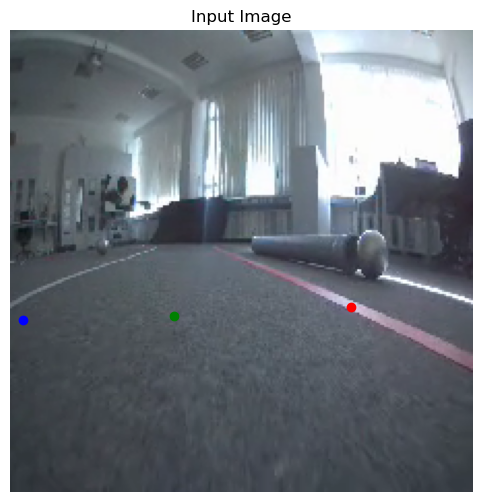

In [27]:
plt.figure(figsize=(12,6))

plt.title("Input Image")
plt.imshow(image)  # convert from C,H,W → H,W,C

#Left (Blue), Center (Green), Right (Red)
plt.plot(pred_x_left, pred_y_left, 'bo')
plt.plot(pred_x_center, pred_y_center, 'go')
plt.plot(pred_x_right, pred_y_right, 'ro')
plt.axis("off")

plt.show()
#plt.savefig("ResNet18_original_14122025")

# Test with random images

In [28]:
#data_dir = r"C:\Users\agah2\Desktop\JupyterNotebooks\BIP\BIP_images_roboter_cam_allinone\val"

data_dir = "./dataset/test_small_dataset"

Random image: frame_007868.png
Done
[[0.08286263 0.60835844 0.26429456 0.6167468  0.5177479  0.63170314]]
left x: 47
left y: 135
center x: 106
center y: 140
right x: 161
right y: 138


C:\Users\agah2\AppData\Local\Temp\ipykernel_2500\1508371580.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_steering_mode

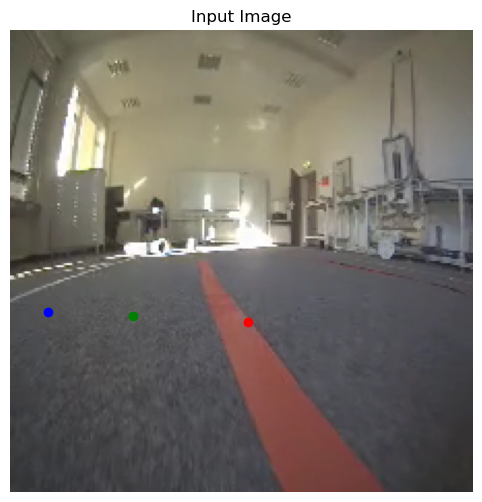

In [32]:
directory = Path(data_dir)
images = [file for file in directory.iterdir()]

random_image = rn.choice(images)
print(f"Random image: {random_image.name}")

image_path = random_image

model.load_state_dict(torch.load('./models/best_steering_model_xy_ResNet18_center_and_lanes_differential_ft.pth'))
model.eval()
print("Done")

output = predict_image(image_path)

pred_coord = output.cpu().numpy()
print(pred_coord)

coordinates = pred_coord[0]

xpred_left = coordinates[0]
ypred_left = coordinates[1]

xpred_center = coordinates[2]
ypred_center = coordinates[3]

xpred_right = coordinates[4]
ypred_right = coordinates[5]

print(f"left x: {pred_x_left}")
print(f"left y: {pred_y_left}")

print(f"center x: {pred_x_center}")
print(f"center y: {pred_y_center}")

print(f"right x: {pred_x_right}")
print(f"right y: {pred_y_right}")

image = Image.open(image_path).convert('RGB')
image_cv = cv2.imread(image_path)

# Denormalize
pred_x_left = int(np.clip(xpred_left * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y_left = int(np.clip(ypred_left * image_cv.shape[0], 0, image_cv.shape[0] - 1))

pred_x_center = int(np.clip(xpred_center * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y_center = int(np.clip(ypred_center * image_cv.shape[0], 0, image_cv.shape[0] - 1))

pred_x_right = int(np.clip(xpred_right * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y_right = int(np.clip(ypred_right * image_cv.shape[0], 0, image_cv.shape[0] - 1))

# Plot
plt.figure(figsize=(12,6))
plt.title("Input Image")
plt.imshow(image)  # convert from C,H,W → H,W,C

plt.plot(pred_x_left, pred_y_left, 'bo')
plt.plot(pred_x_center, pred_y_center, 'go')
plt.plot(pred_x_right, pred_y_right, 'ro')

plt.axis("off")
plt.show()

# Measure time of one prediction on GPU

In [34]:
device = torch.device("cuda")
model.to(device).eval()

dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Warm-up
for _ in range(10):
    _ = model(dummy_input)

# Setup CUDA events
starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)

# Measurement
with torch.no_grad():
    starter.record()
    output = model(dummy_input)
    ender.record()
    
    # Wait for the GPU to finish all work
    torch.cuda.synchronize()
    
    curr_time = starter.elapsed_time(ender) # returns time in milliseconds

print(f"GPU Inference time: {curr_time:.2f} ms")

GPU Inference time: 13.18 ms


# Make multiple predictions and measure average

In [36]:
device = torch.device("cuda")
model.to(device).eval()

# Create dummy input
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Warm-up: 10-20 runs to initialize kernels and memory
print("Warming up")
for _ in range(20):
    _ = model(dummy_input)

# Setup for multiple runs
repetitions = 100
timings = np.zeros((repetitions, 1)) # Array to store results
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

print(f"Starting {repetitions} iterations")

# Measurement Loop
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        
        # WAIT for GPU to finish the work of this specific iteration
        torch.cuda.synchronize()
        
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

# Statistics
mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)

print(f"\n Statistics")
print(f"Average Inference Time: {mean_syn:.3f} ms")
print(f"Standard Deviation:     {std_syn:.3f} ms")
print(f"Throughput:             {1000/mean_syn:.2f} FPS")

Warming up
Starting 100 iterations

 Statistics
Average Inference Time: 4.000 ms
Standard Deviation:     1.029 ms
Throughput:             249.97 FPS


# Predict point in Video

In [37]:
# Configuration
model_path = './models/best_steering_model_xy_ResNet18_center_and_lanes_differential_ft.pth'

#video_path = 'big_corr_w_obs_a_video.mp4'
# u_corr.mp4
video_path = './BIP_videos_roboter_cam/big_corr_w_sun_2.mp4'

#os.chdir('..')
output_video_path = './inference_videos/output_video_ResNet18_center_and_lanes_differential_ft.mp4' # Where the annotated video will be saved

In [38]:
# Defining Image Preprocessing Transforms
# must match the inference transforms from training/testing
inference_transforms = transforms.Compose([
    # Resize the image to 224x224 (standard input size for ResNet)
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    # Normalize using ImageNet stats (standard for ResNet)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [39]:
# Video Processing Loop
def process_video(model, video_path, output_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return

    # Get video properties for saving the output
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Define output video writer
    fourcc = cv2.VideoWriter_fourcc(*'avc1') 
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    frame_count = 0
    print(f"Processing video with {fps} FPS")

    while cap.isOpened():
        ret, frame_cv = cap.read() # Read a frame

        if not ret:
            # End of video stream
            break
        
        frame_count += 1
        
        # Preprocessing (CV2 -> PyTorch Tensor)
        # Convert OpenCV BGR image to PIL RGB image
        frame_rgb = cv2.cvtColor(frame_cv, cv2.COLOR_BGR2RGB)
        frame_pil = Image.fromarray(frame_rgb)

        # Apply transforms
        image_tensor = inference_transforms(frame_pil).unsqueeze(0).to(device) # Add batch dimension (1, 3, H, W) 

        # Inference
        with torch.no_grad():
            output = model(image_tensor).cpu().numpy()[0]
            
        
        # Denormalization and Visualization
        # Denormalize coordinates (from 0.0-1.0 to pixel values)
        x_l, y_l, x_c, y_c, x_r, y_r = output
        #print(output)

        # Denormalize using frame_cv.shape (height=0, width=1)
        h, w = frame_cv.shape[:2]

        pred_x_left = int(np.clip(x_l * w, 0, w - 1))
        pred_y_left = int(np.clip(y_l * h, 0, h - 1))

        pred_x_center = int(np.clip(x_c * w, 0, w - 1))
        pred_y_center = int(np.clip(y_c * h, 0, h - 1))

        pred_x_right = int(np.clip(x_r * w, 0, w - 1))
        pred_y_right = int(np.clip(y_r * h, 0, h - 1))
        
        # Draw circles
        # Left Lane (Red), Center (Green), Right Lane (Blue)
        cv2.circle(frame_cv, (pred_x_left, pred_y_left), 2, (0, 0, 255), -1) 
        cv2.circle(frame_cv, (pred_x_center, pred_y_center), 2, (0, 255, 0), -1)
        cv2.circle(frame_cv, (pred_x_right, pred_y_right), 2, (255, 0, 0), -1)
        
        
        # Draw Steering Vector (Blue Line)
        # From bottom center to the predicted point
        # Steering Vector (Blue line to center point)
        bottom_center = (w // 2, h)
        cv2.line(frame_cv, bottom_center, (pred_x_center, pred_y_center), (255, 0, 0), 2)
        
        # Print center coordinates
        cv2.putText(frame_cv, f'Center: ({pred_x_center}, {pred_y_center})', 
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Display and Save
        out.write(frame_cv)         # Write the annotated frame to the output video
        cv2.imshow('Video Prediction', frame_cv) # Display the frame
        
        # Wait a small amount of time (1 ms) to allow the window to refresh
        # Press 'q' to quit early
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Cleanup
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Processing finished. Annotated video saved to: {output_path}")

In [ ]:
try:
    process_video(model, video_path, output_video_path)
except Exception as e:
    print(f"An error occured: {e}")

In [170]:
Video("./inference_videos/output_video_ResNet18_center_and_lanes_differential_ft.mp4")